In [84]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import seaborn as sns
import random
import implicit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
%matplotlib inline
from graphlab import SFrame
from graphlab import model_parameter_search, SFrame
import graphlab as gl
import graphlab.aggregate as agg

import time
import datetime
import random

import numpy as np
import six
from tabulate import tabulate

from surprise import AlgoBase
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD, evaluate
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import PredictionImpossible
from surprise import dump
from surprise.accuracy import rmse

# Load Data

In [2]:
df=pd.read_excel('Online Retail.xlsx')
len(df)

541909

# Explore Data

In [3]:
df = df.loc[pd.isnull(df.CustomerID) == False]
len(df)

406829

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
item_lookup = df[['StockCode', 'Description']].drop_duplicates() 
# Only get unique item/description pairs

In [6]:
item_lookup['StockCode'] = item_lookup.StockCode.astype(str) 
# Encode as strings for future lookup ease

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [9]:
df['Items']= df['StockCode'].astype(str)+' : '+df['Description'].astype(str)
df.drop(["StockCode", "Description", "Country"], axis=1, inplace=True)
df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Items
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,85123A : WHITE HANGING HEART T-LIGHT HOLDER
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,71053 : WHITE METAL LANTERN
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,84406B : CREAM CUPID HEARTS COAT HANGER
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,84029G : KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,84029E : RED WOOLLY HOTTIE WHITE HEART.


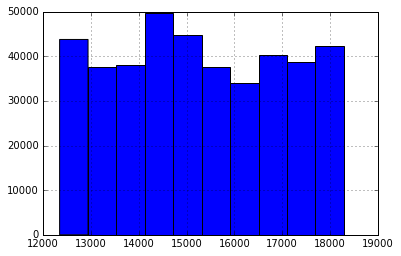

In [10]:
df['CustomerID'].hist()

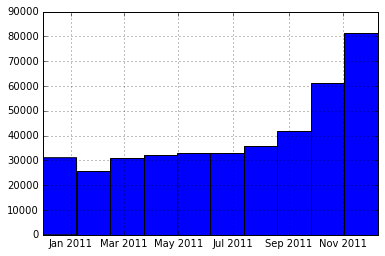

In [11]:
df['InvoiceDate'].hist()

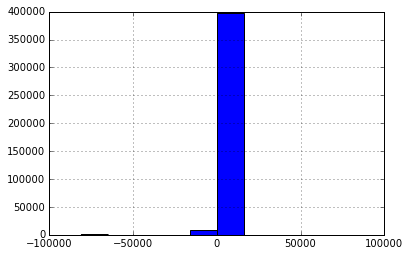

In [12]:
df['Quantity'].hist()

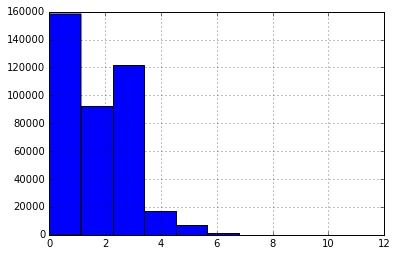

In [13]:
df['Quantity'].apply(np.log).hist()

In [14]:
df['logquant']=df['Quantity'].apply(np.log)
df

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Items,logquant
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,85123A : WHITE HANGING HEART T-LIGHT HOLDER,1.791759
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,71053 : WHITE METAL LANTERN,1.791759
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,84406B : CREAM CUPID HEARTS COAT HANGER,2.079442
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,84029G : KNITTED UNION FLAG HOT WATER BOTTLE,1.791759
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,84029E : RED WOOLLY HOTTIE WHITE HEART.,1.791759
5,536365,2,2010-12-01 08:26:00,7.65,17850.0,22752 : SET 7 BABUSHKA NESTING BOXES,0.693147
6,536365,6,2010-12-01 08:26:00,4.25,17850.0,21730 : GLASS STAR FROSTED T-LIGHT HOLDER,1.791759
7,536366,6,2010-12-01 08:28:00,1.85,17850.0,22633 : HAND WARMER UNION JACK,1.791759
8,536366,6,2010-12-01 08:28:00,1.85,17850.0,22632 : HAND WARMER RED POLKA DOT,1.791759
9,536367,32,2010-12-01 08:34:00,1.69,13047.0,84879 : ASSORTED COLOUR BIRD ORNAMENT,3.465736


In [15]:
df['logquant'].describe()

count    397924.000000
mean          1.648003
std           1.209429
min           0.000000
25%           0.693147
50%           1.791759
75%           2.484907
max          11.302143
Name: logquant, dtype: float64

In [16]:
df['minmaxquant']=df["Quantity"] / df["Quantity"].max()
df

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Items,logquant,minmaxquant
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,85123A : WHITE HANGING HEART T-LIGHT HOLDER,1.791759,0.000074
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,71053 : WHITE METAL LANTERN,1.791759,0.000074
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,84406B : CREAM CUPID HEARTS COAT HANGER,2.079442,0.000099
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,84029G : KNITTED UNION FLAG HOT WATER BOTTLE,1.791759,0.000074
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,84029E : RED WOOLLY HOTTIE WHITE HEART.,1.791759,0.000074
5,536365,2,2010-12-01 08:26:00,7.65,17850.0,22752 : SET 7 BABUSHKA NESTING BOXES,0.693147,0.000025
6,536365,6,2010-12-01 08:26:00,4.25,17850.0,21730 : GLASS STAR FROSTED T-LIGHT HOLDER,1.791759,0.000074
7,536366,6,2010-12-01 08:28:00,1.85,17850.0,22633 : HAND WARMER UNION JACK,1.791759,0.000074
8,536366,6,2010-12-01 08:28:00,1.85,17850.0,22632 : HAND WARMER RED POLKA DOT,1.791759,0.000074
9,536367,32,2010-12-01 08:34:00,1.69,13047.0,84879 : ASSORTED COLOUR BIRD ORNAMENT,3.465736,0.000395


In [17]:
df['CustomerID'] = df.CustomerID.astype(int) 
# Convert to int for customer ID

df = df[['CustomerID','Items', 'Quantity','logquant','minmaxquant', 'InvoiceDate']] 
# Get rid of unnecessary info

df

,CustomerID,Items,Quantity,logquant,minmaxquant,InvoiceDate
0,17850,85123A : WHITE HANGING HEART T-LIGHT HOLDER,6,1.791759,0.000074,2010-12-01 08:26:00
1,17850,71053 : WHITE METAL LANTERN,6,1.791759,0.000074,2010-12-01 08:26:00
2,17850,84406B : CREAM CUPID HEARTS COAT HANGER,8,2.079442,0.000099,2010-12-01 08:26:00
3,17850,84029G : KNITTED UNION FLAG HOT WATER BOTTLE,6,1.791759,0.000074,2010-12-01 08:26:00
4,17850,84029E : RED WOOLLY HOTTIE WHITE HEART.,6,1.791759,0.000074,2010-12-01 08:26:00
5,17850,22752 : SET 7 BABUSHKA NESTING BOXES,2,0.693147,0.000025,2010-12-01 08:26:00
6,17850,21730 : GLASS STAR FROSTED T-LIGHT HOLDER,6,1.791759,0.000074,2010-12-01 08:26:00
7,17850,22633 : HAND WARMER UNION JACK,6,1.791759,0.000074,2010-12-01 08:28:00
8,17850,22632 : HAND WARMER RED POLKA DOT,6,1.791759,0.000074,2010-12-01 08:28:00
9,13047,84879 : ASSORTED COLOUR BIRD ORNAMENT,32,3.465736,0.000395,2010-12-01 08:34:00


In [18]:
df['user_rating']=df.groupby('CustomerID')['Quantity'].transform('count')
df['item_rating']=df.groupby('Items')['Quantity'].transform('count')
df

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,CustomerID,Items,Quantity,logquant,minmaxquant,InvoiceDate,user_rating,item_rating
0,17850,85123A : WHITE HANGING HEART T-LIGHT HOLDER,6,1.791759,0.000074,2010-12-01 08:26:00,312,2070
1,17850,71053 : WHITE METAL LANTERN,6,1.791759,0.000074,2010-12-01 08:26:00,312,259
2,17850,84406B : CREAM CUPID HEARTS COAT HANGER,8,2.079442,0.000099,2010-12-01 08:26:00,312,250
3,17850,84029G : KNITTED UNION FLAG HOT WATER BOTTLE,6,1.791759,0.000074,2010-12-01 08:26:00,312,330
4,17850,84029E : RED WOOLLY HOTTIE WHITE HEART.,6,1.791759,0.000074,2010-12-01 08:26:00,312,333
5,17850,22752 : SET 7 BABUSHKA NESTING BOXES,2,0.693147,0.000025,2010-12-01 08:26:00,312,306
6,17850,21730 : GLASS STAR FROSTED T-LIGHT HOLDER,6,1.791759,0.000074,2010-12-01 08:26:00,312,129
7,17850,22633 : HAND WARMER UNION JACK,6,1.791759,0.000074,2010-12-01 08:28:00,312,477
8,17850,22632 : HAND WARMER RED POLKA DOT,6,1.791759,0.000074,2010-12-01 08:28:00,312,18
9,13047,84879 : ASSORTED COLOUR BIRD ORNAMENT,32,3.465736,0.000395,2010-12-01 08:34:00,196,1418


In [19]:
df['quantityrank'] = df['Quantity'].rank()
df

,CustomerID,Items,Quantity,logquant,minmaxquant,InvoiceDate,user_rating,item_rating,quantityrank
0,17850,85123A : WHITE HANGING HEART T-LIGHT HOLDER,6,1.791759,0.000074,2010-12-01 08:26:00,312,2070,226347.5
1,17850,71053 : WHITE METAL LANTERN,6,1.791759,0.000074,2010-12-01 08:26:00,312,259,226347.5
2,17850,84406B : CREAM CUPID HEARTS COAT HANGER,8,2.079442,0.000099,2010-12-01 08:26:00,312,250,252312.5
3,17850,84029G : KNITTED UNION FLAG HOT WATER BOTTLE,6,1.791759,0.000074,2010-12-01 08:26:00,312,330,226347.5
4,17850,84029E : RED WOOLLY HOTTIE WHITE HEART.,6,1.791759,0.000074,2010-12-01 08:26:00,312,333,226347.5
5,17850,22752 : SET 7 BABUSHKA NESTING BOXES,2,0.693147,0.000025,2010-12-01 08:26:00,312,306,111221.0
6,17850,21730 : GLASS STAR FROSTED T-LIGHT HOLDER,6,1.791759,0.000074,2010-12-01 08:26:00,312,129,226347.5
7,17850,22633 : HAND WARMER UNION JACK,6,1.791759,0.000074,2010-12-01 08:28:00,312,477,226347.5
8,17850,22632 : HAND WARMER RED POLKA DOT,6,1.791759,0.000074,2010-12-01 08:28:00,312,18,226347.5
9,13047,84879 : ASSORTED COLOUR BIRD ORNAMENT,32,3.465736,0.000395,2010-12-01 08:34:00,196,1418,382897.0


In [20]:
df['logquant'].describe()

count    397924.000000
mean          1.648003
std           1.209429
min           0.000000
25%           0.693147
50%           1.791759
75%           2.484907
max          11.302143
Name: logquant, dtype: float64

In [21]:
df.isnull().sum()

CustomerID         0
Items              0
Quantity           0
logquant        8905
minmaxquant        0
InvoiceDate        0
user_rating        0
item_rating        0
quantityrank       0
dtype: int64

In [22]:
dfg = df.groupby(['CustomerID', 'Items']).sum().reset_index() 
# Group together

dfg.logquant.loc[dfg.logquant == 0] = 1 
# Replace a sum of zero purchases with a one to indicate purchased

dfg

C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,CustomerID,Items,Quantity,logquant,minmaxquant,user_rating,item_rating,quantityrank
0,12346,23166 : MEDIUM CERAMIC TOP STORAGE JAR,0,11.214722,0.000000,4,416,406830.0
1,12347,16008 : SMALL FOLDING SCISSOR(POINTED EDGE),24,3.178054,0.000296,182,70,364220.0
2,12347,17021 : NAMASTE SWAGAT INCENSE,36,3.583519,0.000444,182,57,385323.0
3,12347,20665 : RED RETROSPOT PURSE,6,1.791759,0.000074,182,73,226347.5
4,12347,20719 : WOODLAND CHARLOTTE BAG,40,9.210340,0.000494,728,2216,1079644.0
5,12347,20780 : BLACK EAR MUFF HEADPHONES,12,2.484907,0.000148,182,19,310875.0
6,12347,20782 : CAMOUFLAGE EAR MUFF HEADPHONES,6,1.791759,0.000074,182,18,226347.5
7,12347,20966 : SANDWICH BATH SPONGE,10,2.302585,0.000123,182,41,269911.0
8,12347,21035 : SET/2 RED RETROSPOT TEA TOWELS,6,1.791759,0.000074,182,227,226347.5
9,12347,21041 : RED RETROSPOT OVEN GLOVE DOUBLE,12,3.583519,0.000148,364,298,452695.0


In [23]:
dfgp = dfg.query('logquant > 0') 
# Only get customers where purchase totals were positive

dfgp

,CustomerID,Items,Quantity,logquant,minmaxquant,user_rating,item_rating,quantityrank
0,12346,23166 : MEDIUM CERAMIC TOP STORAGE JAR,0,11.214722,0.000000,4,416,406830.0
1,12347,16008 : SMALL FOLDING SCISSOR(POINTED EDGE),24,3.178054,0.000296,182,70,364220.0
2,12347,17021 : NAMASTE SWAGAT INCENSE,36,3.583519,0.000444,182,57,385323.0
3,12347,20665 : RED RETROSPOT PURSE,6,1.791759,0.000074,182,73,226347.5
4,12347,20719 : WOODLAND CHARLOTTE BAG,40,9.210340,0.000494,728,2216,1079644.0
5,12347,20780 : BLACK EAR MUFF HEADPHONES,12,2.484907,0.000148,182,19,310875.0
6,12347,20782 : CAMOUFLAGE EAR MUFF HEADPHONES,6,1.791759,0.000074,182,18,226347.5
7,12347,20966 : SANDWICH BATH SPONGE,10,2.302585,0.000123,182,41,269911.0
8,12347,21035 : SET/2 RED RETROSPOT TEA TOWELS,6,1.791759,0.000074,182,227,226347.5
9,12347,21041 : RED RETROSPOT OVEN GLOVE DOUBLE,12,3.583519,0.000148,364,298,452695.0


In [24]:
dfgp.describe()

,CustomerID,Quantity,logquant,minmaxquant,user_rating,item_rating,quantityrank
count,268408.000000,268408.000000,268408.000000,268408.000000,268408.000000,268408.000000,2.684080e+05
mean,15280.112046,18.360429,2.601069,0.000227,1019.245119,536.804331,3.082996e+05
std,1708.959819,93.890822,3.143652,0.001159,6528.236549,1108.958995,3.444020e+05
min,12346.000000,-72.000000,0.693147,-0.000889,1.000000,1.000000,4.556250e+04
25%,13870.000000,2.000000,1.000000,0.000025,77.000000,118.000000,1.112210e+05
50%,15225.000000,6.000000,1.791759,0.000074,176.000000,258.000000,2.458410e+05
75%,16775.000000,12.000000,2.890372,0.000148,444.000000,547.000000,3.642200e+05
max,18287.000000,12540.000000,137.349462,0.154824,518895.000000,106680.000000,1.435372e+07


In [25]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1,5))

# The columns must correspond to user id, item id and ratings (in that order).
data1 = Dataset.load_from_df(dfgp[['CustomerID', 'Items', 'Quantity']], reader)

# Split the dataset into 5 folds and choose the algorithm
data1.split(n_folds=5)
algo = SVD()

# Train and test reporting the RMSE and MAE scores
evaluate(algo, data1, measures=['RMSE', 'MAE'])

# Retrieve the trainset.
trainset = data1.build_full_trainset()
algo.train(trainset)

# Predict a certain item
userid = str(12347)
itemid = str(21975)
actual_rating = 4
print(algo.predict(userid, itemid, actual_rating))

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data1):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data1)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

C:\ProgramData\Anaconda2\lib\site-packages\surprise\evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
C:\ProgramData\Anaconda2\lib\site-packages\surprise\dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 93.5529
MAE:  15.5760
------------
Fold 2
RMSE: 84.8484
MAE:  15.2406
------------
Fold 3
RMSE: 94.7159
MAE:  16.0032
------------
Fold 4
RMSE: 102.9890
MAE:  15.8430
------------
Fold 5
RMSE: 97.1625
MAE:  15.7026
------------
------------
Mean RMSE: 94.6538
Mean MAE : 15.6731
------------
------------


C:\ProgramData\Anaconda2\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


user: 12347      item: 21975      r_ui = 4.00   est = 5.00   {u'was_impossible': False}
RMSE: 112.8956
RMSE: 82.1362
RMSE: 102.5676
RMSE: 81.6320
RMSE: 91.0717
94.6480928749
{'lr_all': 0.002, 'reg_all': 0.4, 'n_epochs': 5}


In [26]:
algo_svd1 = SVD()                                                       
algo_knn1 = KNNBasic()

for trainset, testset in data1.folds(): 
    algo_svd1.train(trainset)                             
    predictions_svd1 = algo_svd1.test(testset)
    
    algo_knn1.train(trainset)
    predictions_knn1 = algo_knn1.test(testset)
    
    rmse(predictions_svd1)
    rmse(predictions_knn1)                                                                           
    
    dump.dump('./dump_SVD', predictions_svd1, algo_svd1)
    dump.dump('./dump_KNN', predictions_knn1, algo_knn1)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 93.5529
RMSE: 93.5629
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 84.8484
RMSE: 84.8634
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 94.7159
RMSE: 94.7380
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 102.9890
RMSE: 103.0074
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 97.1625
RMSE: 97.1725


In [28]:
# The dumps have been saved and we can now use them whenever we want.

predictions_svd1, algo_svd1 = dump.load('./dump_SVD')
predictions_knn1, algo_knn1 = dump.load('./dump_KNN')

df_svd1 = pd.DataFrame(predictions_svd1, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_knn1 = pd.DataFrame(predictions_knn1, columns=['uid', 'iid', 'rui', 'est', 'details'])    

df_svd1['err'] = abs(df_svd1.est - df_svd1.rui)
df_knn1['err'] = abs(df_knn1.est - df_knn1.rui)

In [29]:
df_svd1.head()

,uid,iid,rui,est,details,err
0,16434,23162 : REGENCY TEA STRAINER,4.0,5,{u'was_impossible': False},1.0
1,17835,20973 : 12 PENCIL SMALL TUBE WOODLAND,8.0,5,{u'was_impossible': False},3.0
2,12480,23208 : LUNCH BAG VINTAGE LEAF DESIGN,10.0,5,{u'was_impossible': False},5.0
3,12524,20728 : LUNCH BAG CARS BLUE,20.0,5,{u'was_impossible': False},15.0
4,16747,22910 : PAPER CHAIN KIT VINTAGE CHRISTMAS,12.0,5,{u'was_impossible': False},7.0


In [30]:
df_knn1.head()

,uid,iid,rui,est,details,err
0,16434,23162 : REGENCY TEA STRAINER,4.0,4.96957,"{u'actual_k': 40, u'was_impossible': False}",0.96957
1,17835,20973 : 12 PENCIL SMALL TUBE WOODLAND,8.0,5.00000,"{u'actual_k': 40, u'was_impossible': False}",3.00000
2,12480,23208 : LUNCH BAG VINTAGE LEAF DESIGN,10.0,5.00000,"{u'actual_k': 40, u'was_impossible': False}",5.00000
3,12524,20728 : LUNCH BAG CARS BLUE,20.0,5.00000,"{u'actual_k': 40, u'was_impossible': False}",15.00000
4,16747,22910 : PAPER CHAIN KIT VINTAGE CHRISTMAS,12.0,5.00000,"{u'actual_k': 40, u'was_impossible': False}",7.00000


<IPython.core.display.Javascript object>


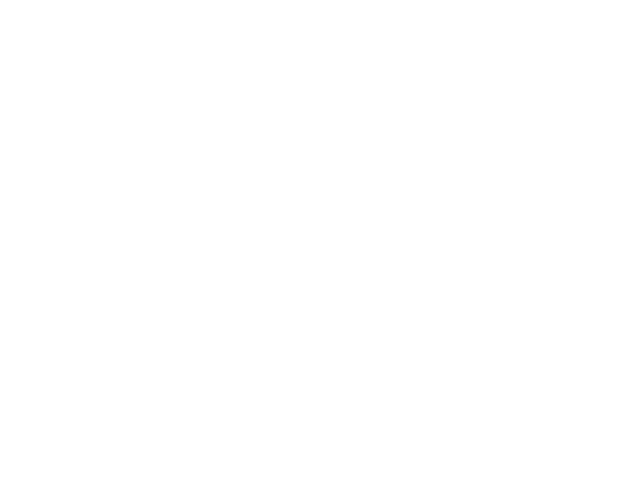

In [31]:
# How different are the predictions from both algorithms ?
# Let's count the number of predictions for each rating value
matplotlib.style.use('ggplot')

figure1, (ax1, ax2) = plt.subplots(1, 2)

df_svd1.est.plot(kind='hist', title='SVD', ax=ax1)
df_knn1.est.plot(kind='hist', title='KNN', ax=ax2)

# As expected, one of the drawbacks of the NN algorithms is that their predictions are often
# quite concentrated around the mean. The SVD algorithm seems more confortable predicting extreme rating values.

In [32]:
param_grid1 = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs1 = GridSearchCV(SVD, param_grid1, measures=['rmse', 'mae'], cv=3)

gs1.fit(data1)

# best RMSE score
print(gs1.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs1.best_params['rmse'])

94.3511695518
{'lr_all': 0.002, 'reg_all': 0.4, 'n_epochs': 5}


In [33]:
# We can now use the algorithm that yields the best rmse:
algo1 = gs1.best_estimator['rmse']
algo1.fit(data1.build_full_trainset())

In [34]:
results_df1 = pd.DataFrame.from_dict(gs1.cv_results)

In [35]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1,5))

# The columns must correspond to user id, item id and ratings (in that order).
data2 = Dataset.load_from_df(dfgp[['CustomerID', 'Items', 'logquant']], reader)

# Split the dataset into 5 folds and choose the algorithm
data2.split(n_folds=5)
algo = SVD()

# Train and test reporting the RMSE and MAE scores
evaluate(algo, data2, measures=['RMSE', 'MAE'])

# Retrieve the trainset.
trainset = data2.build_full_trainset()
algo.train(trainset)

# Predict a certain item
userid = str(12347)
itemid = str(21975)
actual_rating = 4
print(algo.predict(userid, itemid, actual_rating))

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data2):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data2)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 2.6908
MAE:  1.1476
------------
Fold 2
RMSE: 2.8390
MAE:  1.1335
------------
Fold 3
RMSE: 2.6881
MAE:  1.1374
------------
Fold 4
RMSE: 2.7770
MAE:  1.1352
------------
Fold 5
RMSE: 2.7032
MAE:  1.1342
------------
------------
Mean RMSE: 2.7396
Mean MAE : 1.1376
------------
------------
user: 12347      item: 21975      r_ui = 4.00   est = 2.60   {u'was_impossible': False}
RMSE: 2.7529
RMSE: 2.7283
RMSE: 2.8082
RMSE: 2.6885
RMSE: 2.7274
2.73066320752
{'lr_all': 0.005, 'reg_all': 0.4, 'n_epochs': 10}


In [37]:
algo_svd2 = SVD()                                                       
algo_knn2 = KNNBasic()

for trainset, testset in data2.folds(): 
    algo_svd2.train(trainset)                             
    predictions_svd2 = algo_svd2.test(testset)
    
    algo_knn2.train(trainset)
    predictions_knn2 = algo_knn2.test(testset)
    
    rmse(predictions_svd2)
    rmse(predictions_knn2)                                                                           
    
    dump.dump('./dump_SVD', predictions_svd2, algo_svd2)
    dump.dump('./dump_KNN', predictions_knn2, algo_knn2)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.6939
RMSE: 2.9423
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.8387
RMSE: 3.0557
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.6887
RMSE: 2.9151
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.7803
RMSE: 3.0082
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.7059
RMSE: 2.9339


In [38]:
# The dumps have been saved and we can now use them whenever we want.

predictions_svd2, algo_svd2 = dump.load('./dump_SVD')
predictions_knn2, algo_knn2 = dump.load('./dump_KNN')

df_svd2 = pd.DataFrame(predictions_svd2, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_knn2 = pd.DataFrame(predictions_knn2, columns=['uid', 'iid', 'rui', 'est', 'details'])    

df_svd2['err'] = abs(df_svd2.est - df_svd2.rui)
df_knn2['err'] = abs(df_knn2.est - df_knn2.rui)

In [39]:
df_svd2.head()

,uid,iid,rui,est,details,err
0,15676,22809 : SET OF 6 T-LIGHTS SANTA,1.791759,1.960898,{u'was_impossible': False},0.169138
1,17282,"22760 : TRAY, BREAKFAST IN BED",1.000000,1.000000,{u'was_impossible': False},0.000000
2,16293,22633 : HAND WARMER UNION JACK,2.484907,3.582178,{u'was_impossible': False},1.097271
3,13850,23206 : LUNCH BAG APPLE DESIGN,2.302585,2.982533,{u'was_impossible': False},0.679948
4,16385,23503 : PLAYING CARDS KEEP CALM & CARRY ON,2.302585,1.881429,{u'was_impossible': False},0.421156


In [40]:
df_knn2.head()

,uid,iid,rui,est,details,err
0,15676,22809 : SET OF 6 T-LIGHTS SANTA,1.791759,1.774443,"{u'actual_k': 40, u'was_impossible': False}",0.017316
1,17282,"22760 : TRAY, BREAKFAST IN BED",1.000000,1.087896,"{u'actual_k': 35, u'was_impossible': False}",0.087896
2,16293,22633 : HAND WARMER UNION JACK,2.484907,2.399459,"{u'actual_k': 40, u'was_impossible': False}",0.085448
3,13850,23206 : LUNCH BAG APPLE DESIGN,2.302585,3.009089,"{u'actual_k': 40, u'was_impossible': False}",0.706504
4,16385,23503 : PLAYING CARDS KEEP CALM & CARRY ON,2.302585,1.787752,"{u'actual_k': 40, u'was_impossible': False}",0.514833


<IPython.core.display.Javascript object>


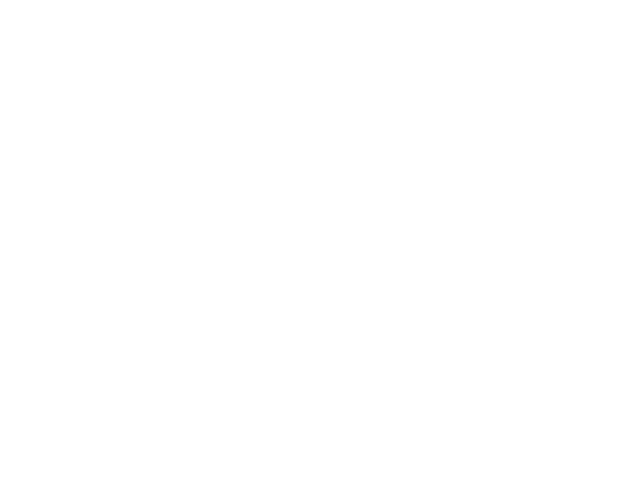

In [41]:
figure2, (ax1, ax2) = plt.subplots(1, 2)

df_svd2.est.plot(kind='hist', title='SVD', ax=ax1)
df_knn2.est.plot(kind='hist', title='KNN', ax=ax2)

# As expected, one of the drawbacks of the NN algorithms is that their predictions are often
# quite concentrated around the mean. The SVD algorithm seems more confortable predicting extreme rating values.

In [42]:
param_grid2 = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs2 = GridSearchCV(SVD, param_grid2, measures=['rmse', 'mae'], cv=3)

gs2.fit(data2)

# best RMSE score
print(gs2.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs2.best_params['rmse'])

2.73736577927
{'lr_all': 0.005, 'reg_all': 0.4, 'n_epochs': 10}


In [43]:
# We can now use the algorithm that yields the best rmse:
algo2 = gs2.best_estimator['rmse']
algo2.fit(data2.build_full_trainset())

In [44]:
results_df2 = pd.DataFrame.from_dict(gs2.cv_results)

In [46]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1,5))

# The columns must correspond to user id, item id and ratings (in that order).
data3 = Dataset.load_from_df(dfgp[['CustomerID', 'Items', 'minmaxquant']], reader)

# Split the dataset into 5 folds and choose the algorithm
data3.split(n_folds=5)
algo = SVD()

# Train and test reporting the RMSE and MAE scores
evaluate(algo, data3, measures=['RMSE', 'MAE'])

# Retrieve the trainset.
trainset = data3.build_full_trainset()
algo.train(trainset)

# Predict a certain item
userid = str(12347)
itemid = str(21975)
actual_rating = 4
print(algo.predict(userid, itemid, actual_rating))

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data3):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data3)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9998
MAE:  0.9998
------------
Fold 2
RMSE: 0.9998
MAE:  0.9998
------------
Fold 3
RMSE: 0.9998
MAE:  0.9998
------------
Fold 4
RMSE: 0.9998
MAE:  0.9998
------------
Fold 5
RMSE: 0.9998
MAE:  0.9998
------------
------------
Mean RMSE: 0.9998
Mean MAE : 0.9998
------------
------------
user: 12347      item: 21975      r_ui = 4.00   est = 1.00   {u'was_impossible': False}
RMSE: 0.9998
RMSE: 0.9998
RMSE: 0.9998
RMSE: 0.9998
RMSE: 0.9998
0.999773986053
{'lr_all': 0.002, 'reg_all': 0.4, 'n_epochs': 5}


In [48]:
algo_svd3 = SVD()                                                       
algo_knn3 = KNNBasic()

for trainset, testset in data3.folds(): 
    algo_svd3.train(trainset)                             
    predictions_svd3 = algo_svd3.test(testset)
    
    algo_knn3.train(trainset)
    predictions_knn3 = algo_knn3.test(testset)
    
    rmse(predictions_svd3)
    rmse(predictions_knn3)                                                                           
    
    dump.dump('./dump_SVD', predictions_svd3, algo_svd3)
    dump.dump('./dump_KNN', predictions_knn3, algo_knn3)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9998
RMSE: 0.9998
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9998
RMSE: 0.9998
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9998
RMSE: 0.9998
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9998
RMSE: 0.9998
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9998
RMSE: 0.9998


In [49]:
# The dumps have been saved and we can now use them whenever we want.

predictions_svd3, algo_svd3 = dump.load('./dump_SVD')
predictions_knn3, algo_knn3 = dump.load('./dump_KNN')

df_svd3 = pd.DataFrame(predictions_svd3, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_knn3 = pd.DataFrame(predictions_knn3, columns=['uid', 'iid', 'rui', 'est', 'details'])    

df_svd3['err'] = abs(df_svd3.est - df_svd3.rui)
df_knn3['err'] = abs(df_knn3.est - df_knn3.rui)

In [50]:
df_svd3.head()

,uid,iid,rui,est,details,err
0,15483,22449 : SILK PURSE BABUSHKA PINK,0.000012,1,{u'was_impossible': False},0.999988
1,14419,23240 : SET OF 4 KNICK KNACK TINS DOILY,0.000123,1,{u'was_impossible': False},0.999877
2,18016,82494L : WOODEN FRAME ANTIQUE WHITE,0.000074,1,{u'was_impossible': False},0.999926
3,12681,21989 : PACK OF 20 SKULL PAPER NAPKINS,0.000296,1,{u'was_impossible': False},0.999704
4,17961,21086 : SET/6 RED SPOTTY PAPER CUPS,0.000173,1,{u'was_impossible': False},0.999827


In [51]:
df_knn3.head()

,uid,iid,rui,est,details,err
0,15483,22449 : SILK PURSE BABUSHKA PINK,0.000012,1,"{u'actual_k': 40, u'was_impossible': False}",0.999988
1,14419,23240 : SET OF 4 KNICK KNACK TINS DOILY,0.000123,1,"{u'actual_k': 40, u'was_impossible': False}",0.999877
2,18016,82494L : WOODEN FRAME ANTIQUE WHITE,0.000074,1,"{u'actual_k': 40, u'was_impossible': False}",0.999926
3,12681,21989 : PACK OF 20 SKULL PAPER NAPKINS,0.000296,1,"{u'actual_k': 40, u'was_impossible': False}",0.999704
4,17961,21086 : SET/6 RED SPOTTY PAPER CUPS,0.000173,1,"{u'actual_k': 40, u'was_impossible': False}",0.999827


<IPython.core.display.Javascript object>


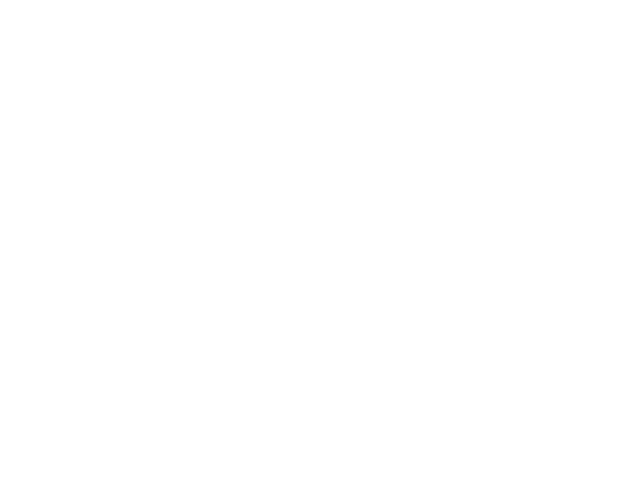

In [52]:
figure3, (ax1, ax2) = plt.subplots(1, 2)

df_svd3.est.plot(kind='hist', title='SVD', ax=ax1)
df_knn3.est.plot(kind='hist', title='KNN', ax=ax2)

# As expected, one of the drawbacks of the NN algorithms is that their predictions are often
# quite concentrated around the mean. The SVD algorithm seems more confortable predicting extreme rating values.

In [53]:
param_grid3 = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs3 = GridSearchCV(SVD, param_grid3, measures=['rmse', 'mae'], cv=3)

gs3.fit(data3)

# best RMSE score
print(gs3.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs3.best_params['rmse'])

0.999773986094
{'lr_all': 0.002, 'reg_all': 0.4, 'n_epochs': 5}


In [54]:
# We can now use the algorithm that yields the best rmse:
algo3 = gs3.best_estimator['rmse']
algo3.fit(data3.build_full_trainset())

In [55]:
results_df3 = pd.DataFrame.from_dict(gs3.cv_results)

In [56]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1,5))

# The columns must correspond to user id, item id and ratings (in that order).
data4 = Dataset.load_from_df(dfgp[['CustomerID', 'Items', 'quantityrank']], reader)

# Split the dataset into 5 folds and choose the algorithm
data4.split(n_folds=5)
algo = SVD()

# Train and test reporting the RMSE and MAE scores
evaluate(algo, data4, measures=['RMSE', 'MAE'])

# Retrieve the trainset.
trainset = data4.build_full_trainset()
algo.train(trainset)

# Predict a certain item
userid = str(12347)
itemid = str(21975)
actual_rating = 4
print(algo.predict(userid, itemid, actual_rating))

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data4):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data4)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 467264.1126
MAE:  309725.3191
------------
Fold 2
RMSE: 460791.4842
MAE:  308633.5150
------------
Fold 3
RMSE: 459174.5990
MAE:  305693.7139
------------
Fold 4
RMSE: 462679.2570
MAE:  309512.4255
------------
Fold 5
RMSE: 461206.5396
MAE:  307908.2031
------------
------------
Mean RMSE: 462223.1985
Mean MAE : 308294.6353
------------
------------
user: 12347      item: 21975      r_ui = 4.00   est = 5.00   {u'was_impossible': False}
RMSE: 468157.5859
RMSE: 467281.0413
RMSE: 459994.1960
RMSE: 460684.0336
RMSE: 454908.5012
462190.612457
{'lr_all': 0.002, 'reg_all': 0.4, 'n_epochs': 5}


In [58]:
algo_svd4 = SVD()                                                       
algo_knn4 = KNNBasic()

for trainset, testset in data4.folds(): 
    algo_svd4.train(trainset)                             
    predictions_svd4 = algo_svd4.test(testset)
    
    algo_knn4.train(trainset)
    predictions_knn4 = algo_knn4.test(testset)
    
    rmse(predictions_svd4)
    rmse(predictions_knn4)                                                                           
    
    dump.dump('./dump_SVD', predictions_svd4, algo_svd4)
    dump.dump('./dump_KNN', predictions_knn4, algo_knn4)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 467264.1126
RMSE: 467264.1126
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 460791.4842
RMSE: 460791.4842
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 459174.5990
RMSE: 459174.5990
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 462679.2570
RMSE: 462679.2570
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 461206.5396
RMSE: 461206.5396


In [59]:
# The dumps have been saved and we can now use them whenever we want.

predictions_svd4, algo_svd4 = dump.load('./dump_SVD')
predictions_knn4, algo_knn4 = dump.load('./dump_KNN')

df_svd4 = pd.DataFrame(predictions_svd4, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_knn4 = pd.DataFrame(predictions_knn4, columns=['uid', 'iid', 'rui', 'est', 'details'])    

df_svd4['err'] = abs(df_svd4.est - df_svd4.rui)
df_knn4['err'] = abs(df_knn4.est - df_knn4.rui)

In [60]:
df_svd4.head()

,uid,iid,rui,est,details,err
0,14985,22633 : HAND WARMER UNION JACK,45562.5,5,{u'was_impossible': False},45557.5
1,13560,21166 : COOK WITH WINE METAL SIGN,153696.5,5,{u'was_impossible': False},153691.5
2,14711,23151 : ZINC SWEETHEART SOAP DISH,91125.0,5,{u'was_impossible': False},91120.0
3,17406,21733 : RED HANGING HEART T-LIGHT HOLDER,153696.5,5,{u'was_impossible': False},153691.5
4,16271,22686 : FRENCH BLUE METAL DOOR SIGN No,45562.5,5,{u'was_impossible': False},45557.5


In [61]:
df_knn4.head()

,uid,iid,rui,est,details,err
0,14985,22633 : HAND WARMER UNION JACK,45562.5,5,"{u'actual_k': 40, u'was_impossible': False}",45557.5
1,13560,21166 : COOK WITH WINE METAL SIGN,153696.5,5,"{u'actual_k': 40, u'was_impossible': False}",153691.5
2,14711,23151 : ZINC SWEETHEART SOAP DISH,91125.0,5,"{u'actual_k': 15, u'was_impossible': False}",91120.0
3,17406,21733 : RED HANGING HEART T-LIGHT HOLDER,153696.5,5,"{u'actual_k': 40, u'was_impossible': False}",153691.5
4,16271,22686 : FRENCH BLUE METAL DOOR SIGN No,45562.5,5,"{u'actual_k': 27, u'was_impossible': False}",45557.5


<IPython.core.display.Javascript object>


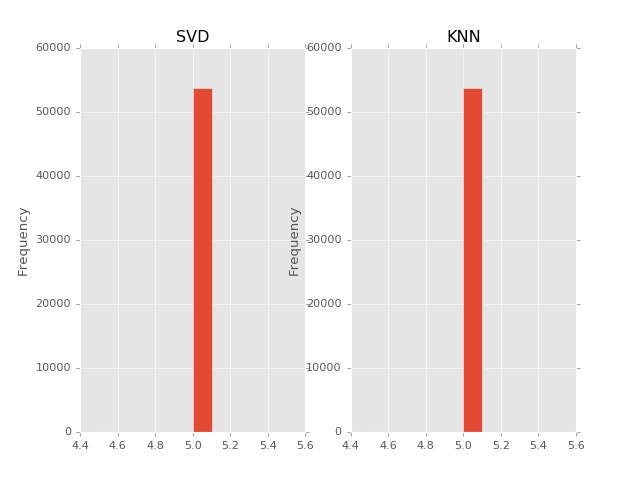

In [62]:
figure4, (ax1, ax2) = plt.subplots(1, 2)

df_svd4.est.plot(kind='hist', title='SVD', ax=ax1)
df_knn4.est.plot(kind='hist', title='KNN', ax=ax2)

# As expected, one of the drawbacks of the NN algorithms is that their predictions are often
# quite concentrated around the mean. The SVD algorithm seems more confortable predicting extreme rating values.

In [63]:
param_grid4 = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs4 = GridSearchCV(SVD, param_grid4, measures=['rmse', 'mae'], cv=3)

gs4.fit(data4)

# best RMSE score
print(gs4.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs4.best_params['rmse'])

462222.063988
{'lr_all': 0.002, 'reg_all': 0.4, 'n_epochs': 10}


In [64]:
# We can now use the algorithm that yields the best rmse:
algo4 = gs4.best_estimator['rmse']
algo4.fit(data4.build_full_trainset())

In [65]:
results_df4 = pd.DataFrame.from_dict(gs4.cv_results)

In [66]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1,5))

# The columns must correspond to user id, item id and ratings (in that order).
data5 = Dataset.load_from_df(dfgp[['CustomerID', 'Items', 'user_rating']], reader)

# Split the dataset into 5 folds and choose the algorithm
data5.split(n_folds=5)
algo = SVD()

# Train and test reporting the RMSE and MAE scores
evaluate(algo, data5, measures=['RMSE', 'MAE'])

# Retrieve the trainset.
trainset = data5.build_full_trainset()
algo.train(trainset)

# Predict a certain item
userid = str(12347)
itemid = str(21975)
actual_rating = 4
print(algo.predict(userid, itemid, actual_rating))

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data5):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data5)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 7128.1767
MAE:  1013.4132
------------
Fold 2
RMSE: 6697.2358
MAE:  1054.1516
------------
Fold 3
RMSE: 6971.9453
MAE:  1046.7439
------------
Fold 4
RMSE: 5932.4845
MAE:  973.1135
------------
Fold 5
RMSE: 6226.1964
MAE:  983.8353
------------
------------
Mean RMSE: 6591.2077
Mean MAE : 1014.2515
------------
------------
user: 12347      item: 21975      r_ui = 4.00   est = 5.00   {u'was_impossible': False}
RMSE: 7732.6358
RMSE: 6421.5027
RMSE: 6871.3986
RMSE: 6092.4176
RMSE: 5733.1219
6600.08617016
{'lr_all': 0.002, 'reg_all': 0.4, 'n_epochs': 5}


In [67]:
algo_svd5 = SVD()                                                       
algo_knn5 = KNNBasic()

for trainset, testset in data5.folds(): 
    algo_svd5.train(trainset)                             
    predictions_svd5 = algo_svd5.test(testset)
    
    algo_knn5.train(trainset)
    predictions_knn5 = algo_knn5.test(testset)
    
    rmse(predictions_svd5)
    rmse(predictions_knn5)                                                                           
    
    dump.dump('./dump_SVD', predictions_svd5, algo_svd5)
    dump.dump('./dump_KNN', predictions_knn5, algo_knn5)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 7128.1767
RMSE: 7128.1767
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 6697.2358
RMSE: 6697.2358
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 6971.9453
RMSE: 6971.9453
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 5932.4845
RMSE: 5932.4845
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 6226.1964
RMSE: 6226.1964


In [68]:
# The dumps have been saved and we can now use them whenever we want.

predictions_svd5, algo_svd5 = dump.load('./dump_SVD')
predictions_knn5, algo_knn5 = dump.load('./dump_KNN')

df_svd5 = pd.DataFrame(predictions_svd5, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_knn5 = pd.DataFrame(predictions_knn5, columns=['uid', 'iid', 'rui', 'est', 'details'])    

df_svd5['err'] = abs(df_svd5.est - df_svd5.rui)
df_knn5['err'] = abs(df_knn5.est - df_knn5.rui)

In [69]:
df_svd5.head()

,uid,iid,rui,est,details,err
0,17450,21955 : DOORMAT UNION JACK GUNS AND ROSES,351.0,5,{u'was_impossible': False},346.0
1,16283,21504 : SKULLS GREETING CARD,168.0,5,{u'was_impossible': False},163.0
2,15719,23284 : DOORMAT KEEP CALM AND COME IN,1876.0,5,{u'was_impossible': False},1871.0
3,13717,21116 : OWL DOORSTOP,103.0,5,{u'was_impossible': False},98.0
4,17585,85032C : CURIOUS IMAGES GIFT WRAP SET,428.0,5,{u'was_impossible': False},423.0


In [70]:
df_knn5.head()

,uid,iid,rui,est,details,err
0,17450,21955 : DOORMAT UNION JACK GUNS AND ROSES,351.0,5.0,"{u'actual_k': 40, u'was_impossible': False}",346.0
1,16283,21504 : SKULLS GREETING CARD,168.0,5.0,"{u'actual_k': 40, u'was_impossible': False}",163.0
2,15719,23284 : DOORMAT KEEP CALM AND COME IN,1876.0,5.0,"{u'actual_k': 40, u'was_impossible': False}",1871.0
3,13717,21116 : OWL DOORSTOP,103.0,5.0,"{u'actual_k': 40, u'was_impossible': False}",98.0
4,17585,85032C : CURIOUS IMAGES GIFT WRAP SET,428.0,5.0,"{u'actual_k': 40, u'was_impossible': False}",423.0


<IPython.core.display.Javascript object>


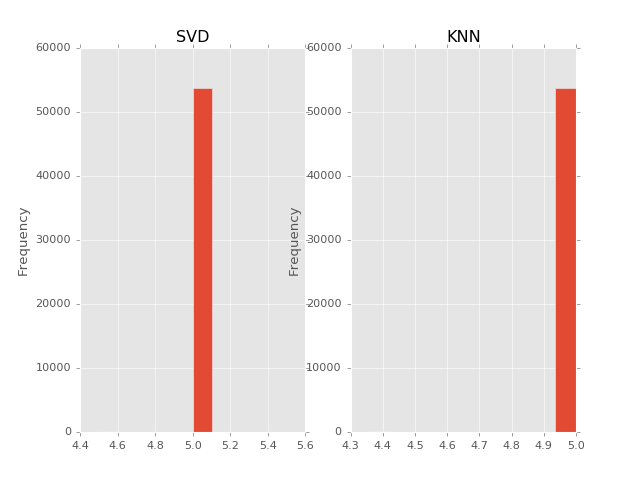

In [71]:
figure5, (ax1, ax2) = plt.subplots(1, 2)

df_svd5.est.plot(kind='hist', title='SVD', ax=ax1)
df_knn5.est.plot(kind='hist', title='KNN', ax=ax2)

# As expected, one of the drawbacks of the NN algorithms is that their predictions are often
# quite concentrated around the mean. The SVD algorithm seems more confortable predicting extreme rating values.

In [72]:
param_grid5 = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs5 = GridSearchCV(SVD, param_grid5, measures=['rmse', 'mae'], cv=3)

gs5.fit(data5)

# best RMSE score
print(gs5.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs5.best_params['rmse'])

6605.66201211
{'lr_all': 0.002, 'reg_all': 0.4, 'n_epochs': 5}


In [73]:
# We can now use the algorithm that yields the best rmse:
algo5 = gs5.best_estimator['rmse']
algo5.fit(data5.build_full_trainset())

In [74]:
results_df5 = pd.DataFrame.from_dict(gs5.cv_results)

In [75]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1,5))

# The columns must correspond to user id, item id and ratings (in that order).
data6 = Dataset.load_from_df(dfgp[['CustomerID', 'Items', 'item_rating']], reader)

# Split the dataset into 5 folds and choose the algorithm
data6.split(n_folds=5)
algo = SVD()

# Train and test reporting the RMSE and MAE scores
evaluate(algo, data6, measures=['RMSE', 'MAE'])

# Retrieve the trainset.
trainset = data6.build_full_trainset()
algo.train(trainset)

# Predict a certain item
userid = str(12347)
itemid = str(21975)
actual_rating = 4
print(algo.predict(userid, itemid, actual_rating))

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data6):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data6)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 1184.6575
MAE:  524.3479
------------
Fold 2
RMSE: 1198.4709
MAE:  530.1895
------------
Fold 3
RMSE: 1198.2690
MAE:  534.1974
------------
Fold 4
RMSE: 1242.8068
MAE:  534.3833
------------
Fold 5
RMSE: 1320.1698
MAE:  535.9980
------------
------------
Mean RMSE: 1228.8748
Mean MAE : 531.8232
------------
------------
user: 12347      item: 21975      r_ui = 4.00   est = 5.00   {u'was_impossible': False}
RMSE: 1286.3518
RMSE: 1191.5968
RMSE: 1176.2827
RMSE: 1201.7478
RMSE: 1288.6293
1228.52385561
{'lr_all': 0.002, 'reg_all': 0.4, 'n_epochs': 5}


In [76]:
algo_svd6 = SVD()                                                       
algo_knn6 = KNNBasic()

for trainset, testset in data6.folds(): 
    algo_svd6.train(trainset)                             
    predictions_svd6 = algo_svd6.test(testset)
    
    algo_knn6.train(trainset)
    predictions_knn6 = algo_knn6.test(testset)
    
    rmse(predictions_svd6)
    rmse(predictions_knn6)                                                                           
    
    dump.dump('./dump_SVD', predictions_svd6, algo_svd6)
    dump.dump('./dump_KNN', predictions_knn6, algo_knn6)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1184.6575
RMSE: 1184.6575
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1198.4709
RMSE: 1198.4709
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1198.2690
RMSE: 1198.2690
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1242.8068
RMSE: 1242.8068
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1320.1698
RMSE: 1320.1698


In [77]:
# The dumps have been saved and we can now use them whenever we want.

predictions_svd6, algo_svd6 = dump.load('./dump_SVD')
predictions_knn6, algo_knn6 = dump.load('./dump_KNN')

df_svd6 = pd.DataFrame(predictions_svd6, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_knn6 = pd.DataFrame(predictions_knn6, columns=['uid', 'iid', 'rui', 'est', 'details'])    

df_svd6['err'] = abs(df_svd6.est - df_svd6.rui)
df_knn6['err'] = abs(df_knn6.est - df_knn6.rui)

In [78]:
df_svd6.head()

,uid,iid,rui,est,details,err
0,18041,23401 : RUSTIC MIRROR WITH LACE HEART,73.0,5,{u'was_impossible': False},68.0
1,14621,22743 : MAKE YOUR OWN FLOWERPOWER CARD KIT,306.0,5,{u'was_impossible': False},301.0
2,17561,23295 : SET OF 12 MINI LOAF BAKING CASES,375.0,5,{u'was_impossible': False},370.0
3,16115,23202 : JUMBO BAG VINTAGE LEAF,1576.0,5,{u'was_impossible': False},1571.0
4,16033,21907 : I'M ON HOLIDAY METAL SIGN,668.0,5,{u'was_impossible': False},663.0


In [79]:
df_knn6.head()

,uid,iid,rui,est,details,err
0,18041,23401 : RUSTIC MIRROR WITH LACE HEART,73.0,5.0,"{u'actual_k': 40, u'was_impossible': False}",68.0
1,14621,22743 : MAKE YOUR OWN FLOWERPOWER CARD KIT,306.0,5.0,"{u'actual_k': 40, u'was_impossible': False}",301.0
2,17561,23295 : SET OF 12 MINI LOAF BAKING CASES,375.0,5.0,"{u'actual_k': 40, u'was_impossible': False}",370.0
3,16115,23202 : JUMBO BAG VINTAGE LEAF,1576.0,5.0,"{u'actual_k': 40, u'was_impossible': False}",1571.0
4,16033,21907 : I'M ON HOLIDAY METAL SIGN,668.0,5.0,"{u'actual_k': 40, u'was_impossible': False}",663.0


<IPython.core.display.Javascript object>


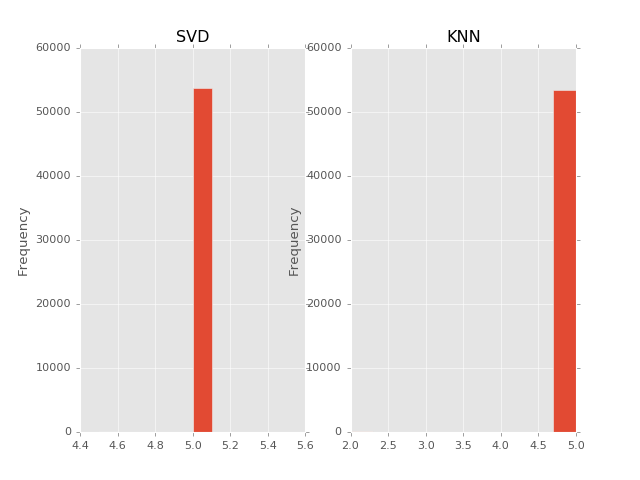

In [80]:
figure6, (ax1, ax2) = plt.subplots(1, 2)

df_svd6.est.plot(kind='hist', title='SVD', ax=ax1)
df_knn6.est.plot(kind='hist', title='KNN', ax=ax2)

# As expected, one of the drawbacks of the NN algorithms is that their predictions are often
# quite concentrated around the mean. The SVD algorithm seems more confortable predicting extreme rating values.

In [81]:
param_grid6 = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs6 = GridSearchCV(SVD, param_grid6, measures=['rmse', 'mae'], cv=3)

gs6.fit(data6)

# best RMSE score
print(gs6.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs6.best_params['rmse'])

1229.63273917
{'lr_all': 0.002, 'reg_all': 0.4, 'n_epochs': 5}


In [82]:
# We can now use the algorithm that yields the best rmse:
algo6 = gs6.best_estimator['rmse']
algo6.fit(data6.build_full_trainset())

In [83]:
results_df6 = pd.DataFrame.from_dict(gs6.cv_results)

In [ ]:
# Let's check how good are the KNN predictions when the SVD has a huge error:
df_knn[df_svd.err >= 3.5]

In [ ]:
# Well... Not much better.
# Now, let's look at the predictions of SVD on the 10 worst predictions for KNN
df_svd.iloc[df_knn.sort_values(by='err')[-10:].index]